In [1]:
# output id and title of each song

from music21 import *

chinese_folk=corpus.search('china','locale')
[(i,e.metadata.title) for i,e in enumerate(chinese_folk)] 

[(0, 'Luoshui tian'),
 (1, 'Gua difeng'),
 (2, 'Lishui chuangong haozi  1.'),
 (3, 'Genzhe taiyang yilu lai'),
 (4, 'Hua he bao'),
 (5, 'Hao cao ge'),
 (6, 'Xiao baicai'),
 (7, 'Hong xiu xie , cf. Dong fang Hong!)'),
 (8, 'Xin bian de Shange,yong che la'),
 (9, 'Tiqi gege zou xikou'),
 (10, 'Zuo lou ge'),
 (11, 'Shi dajie'),
 (12, 'Liuliu ge'),
 (13, 'Nao yuanxiao'),
 (14, 'Dizhu zhangde shi hulang xin'),
 (15, 'Xiaoxiao shuiche chang you chang'),
 (16, 'Xiu he bao'),
 (17, 'Guazi hung'),
 (18, 'Mama niang ni hao hutu'),
 (19, 'Da xie di'),
 (20, 'Shun caicha'),
 (21, 'Yueliang wanwan zhao jiuzhou'),
 (22, 'Fan Dui hua'),
 (23, 'Ma ju ju'),
 (24, 'Haolang haojie bu yong mei'),
 (25, 'Yi zhan mingdeng zhao Beijing'),
 (26, 'Tuichuan haozi'),
 (27, 'Renmin gongshe zhenzheng hao'),
 (28, 'Chouchou zhenjiao lang moxian'),
 (29, 'Zhongren kangshan shan hui dong'),
 (30, 'Zhonghua'),
 (31, 'Haozi benlai shi lingqi'),
 (32, 'Fang fengzheng'),
 (33, 'Gu zhi diao'),
 (34, 'Gusu fengguang (Da ji

In [2]:
from music21 import *

import logging
import copy
import math
import numpy as np

def gen_time_unit(m_time_signature):
    return 4/m_time_signature.denominator

def add_chord(s,part_idx=0,chords=None):
    s=copy.deepcopy(s)
    new_part=s.parts[part_idx].template(fillWithRests=False)
    score_time_signatures=s.getElementsByClass(meter.TimeSignature)
    if len(score_time_signatures)>0:
        score_time_signature=score_time_signatures[0]
    else:
        score_time_signature=None
    num_measures=len(new_part.getElementsByClass('Measure'))
    if num_measures==0:
        print("no measure in this song. failed to add chords.")
        return s
    cidx=-1
    for i in range(num_measures+1):
        m=new_part.measure(i)
        if m is not None:
            m.duration.quarterLength=s.parts[part_idx].measure(i).duration.quarterLength
            if m.duration.quarterLength>0:
                if m.timeSignature is not None:
                    m_time_signature=m.timeSignature
                    if score_time_signature is None:
                        score_time_signature=m_time_signature
                else:
                    m_time_signature=score_time_signature
                if m_time_signature is not None:
                    time_unit=gen_time_unit(m_time_signature)
                else:
                    time_unit=1
                if chords is None:
                    cMinor = chord.Chord(["D4","F4","A4"])
                    cMinor.duration.type = 'quarter'
                    cMajor = chord.Chord(["C4","G4"])
                    cMajor.duration.type = 'quarter'
                    m.append(cMinor)
                    m.append(cMajor)
                else:
                    steps=int(m.duration.quarterLength/time_unit)
                    logging.debug("%f %f %d",m.duration.quarterLength,time_unit,steps)
                    for _ in range(steps):
                        cidx=(cidx+1)%len(chords)
                        c=copy.copy(chords[cidx])
                        c.duration.quarterLength=time_unit
                        m.append(c)
            else:
                logging.debug("the duration of measure %d is %f" %(i,m.duration.quarterLength))
        else:
            logging.debug("measure %d is None" %i)
    s.append(new_part)
    return s

def sort_notes(s):
    parts=s.parts
    notes_list=[[e for e in p.flatten() if isinstance(e,note.Note)] for p in parts]
    for notes in notes_list:
        notes.sort(key=lambda e:e.offset)
    return notes_list
   
def gen_timeline_of_notes(s):
    notes_list=sort_notes(s)
    all_ts=[e for e in s.flatten().getElementsByClass(meter.TimeSignature)]
    all_denominators=list(set([e.denominator for e in all_ts]))
    if not all_denominators:
        return None
    denominator=max(all_denominators)
    for e in all_denominators:
        if denominator%e!=0:
            return None
    time_unit=4/denominator
    score_len=int(s.duration.quarterLength/time_unit)
    parts=s.parts
    timeline_of_notes=[[None for _ in range(score_len)] for _ in parts]
    for i in range(len(parts)):
        for n in notes_list[i]:
            duration_range=math.ceil(n.duration.quarterLength/time_unit)
            for j in range(duration_range):
                timeline_idx=math.floor((n.offset+j*time_unit)/time_unit)
                if timeline_of_notes[i][timeline_idx] is None:
                    timeline_of_notes[i][timeline_idx]=n
    return timeline_of_notes

def get_melody_chord(s):
    timeline_of_notes=gen_timeline_of_notes(s)
    if timeline_of_notes is None:
        return None,None
    #len(timeline_of_notes) is the number of parts of score s
    assert(timeline_of_notes)
    assert(len(set([len(e) for e in timeline_of_notes]))==1)
    timeline_len=len(timeline_of_notes[0])
    timeline=[[e[i] for e in timeline_of_notes if e[i] is not None] for i in range(timeline_len)]
    timeline=[e for e in timeline if len(e)==len(timeline_of_notes)]
    for e in timeline:
        e.sort()
    melody=[e[-1] for e in timeline] #e[-1] is the highest note
    chords=[chord.Chord(e[:-1]).closedPosition(leaveRedundantPitches=False) for e in timeline]
    return melody,chords
   
class NameMgr(object):
    def __init__(self):
        self.name_map={}
        self.name_list=[]
        self.name_count_list=[]
   
    def add_item(self,n):
        if n not in self.name_map:
            self.name_map[n]=len(self.name_list)
            self.name_list.append(n)
            self.name_count_list.append(1)
        else:
            self.name_count_list[self.get_id_by_name(n)]+=1
   
    def get_id_by_name(self,name):
        return self.name_map[name]
   
    def get_name_by_id(self,id):
        return self.name_list[id]
   
    def size(self):
        return len(self.name_map)
   
    def summary(self):
        for i,(name,count) in enumerate(zip(self.name_list,self.name_count_list)):
            print(i,name,count)

            import HMM
class PitchNameUnifier(object):
    def __init__(self):
        super().__init__()
        self.map={'A#':'B-', 'C#':'D-', 'D#':'E-', 'E#':'F', 'F#':'G-', 'G#':'A-'}
   
    def unified_name(self,n):
        return self.map.get(n,n)

def chord_to_str(c,pitch_name_unifier,normalize=True):
    sorted_pitches=sorted(c.pitches)
    if normalize:
        return " ".join(["%s%d" %(pitch_name_unifier.unified_name(p.name),p.octave-sorted_pitches[0].octave+1) for p in sorted_pitches])
    return " ".join(["%s%d" %(pitch_name_unifier.unified_name(p.name),p.octave) for p in sorted_pitches])

def chord_from_str(s):
    return chord.Chord([pitch.Pitch(e) for e in s.split(" ")])

def viterbi(transprob,emiprob,pi,obs):
    n = len(obs)
    m = len(transprob[0])
    hid = [0]*n
    node = [[0]*m for _ in range(n)]
    prob = [[0]*m for _ in range(n)]
    for i in range(m):
        node[0][i] = 0
        prob[0][i] = pi[i]*emiprob[i][obs[0]]
    for k in range(1,n):
        for i in range(m):
            tmp,idx = 0,0
            for j in range(m):
                res = prob[k-1][j]*transprob[j][i]
                if res>tmp:
                    tmp = res
                    idx = j
            node[k][i] = idx
            prob[k][i] = tmp*emiprob[i][obs[k]]
    p = max(prob[-1])
    for i in range(m):
        if prob[-1][i] == p:
            tmp = i
    i_k = tmp
    for k in reversed(range(n-1)):
        i_k = node[k+1][i_k]
        hid[k] = i_k
    hid[-1] = tmp
    return hid

class Harmonizer(object):
    def __init__(self,normalize=True):
        super().__init__()
        self.normalize=normalize
        self.V=None #intial
        self.T=None #transition
        self.E=None #emission
        self.V_map={}
        self.T_map={}
        self.E_map={}
        self.notes_mgr=None
        self.chords_mgr=None
        self.normal_order_map={}
   
    def clone(self):
        h=Harmonizer()
        h.normalize=self.normalize
        h.V=self.V
        h.T=self.T
        h.E=self.E
        h.notes_mgr=self.notes_mgr
        h.chords_mgr=self.chords_mgr
        return h
   
    def analyze_scores(self,scores):
        self.notes_mgr=NameMgr()
        self.chords_mgr=NameMgr()
        V_map={}
        T_map={}
        E_map={}
        pitch_name_unifier=PitchNameUnifier()
        for s in scores:
            melody,chords = get_melody_chord(s)
            if melody is None:
                continue
            assert len(melody)==len(chords)
            if len(chords)>1:
                for n in melody:
                    self.notes_mgr.add_item(pitch_name_unifier.unified_name(n.name))
                for c in chords:
                    self.chords_mgr.add_item(chord_to_str(c,pitch_name_unifier,normalize=self.normalize))
                    if c.normalOrderString not in self.normal_order_map:
                        self.normal_order_map[c.normalOrderString]=set()
                    self.normal_order_map[c.normalOrderString].add(chord_to_str(c,pitch_name_unifier,normalize=self.normalize))
                first_chord_id=self.chords_mgr.get_id_by_name(chord_to_str(chords[0],pitch_name_unifier,normalize=self.normalize))
                V_map[first_chord_id]=V_map.get(first_chord_id,0)+1
                for i in range(len(chords)-1):
                    c1_id=self.chords_mgr.get_id_by_name(chord_to_str(chords[i],pitch_name_unifier,normalize=self.normalize))
                    c2_id=self.chords_mgr.get_id_by_name(chord_to_str(chords[i+1],pitch_name_unifier,normalize=self.normalize))
                    T_map[(c1_id,c2_id)]=T_map.get((c1_id,c2_id),0)+1
                for n,c in zip(melody,chords):
                    c_id=self.chords_mgr.get_id_by_name(chord_to_str(c,pitch_name_unifier,normalize=self.normalize))
                    n_id=self.notes_mgr.get_id_by_name(pitch_name_unifier.unified_name(n.name))
                    E_map[(c_id,n_id)]=E_map.get((c_id,n_id),0)+1

        self.V_map=V_map
        self.T_map=T_map
        self.E_map=E_map
   
    def gen_model(self,V_map,T_map,E_map):
        epsilon=0.000001
        self.V=np.zeros(self.chords_mgr.size())
        for c_id,count in V_map.items():
            self.V[c_id]=count
        self.V+=epsilon # everyone has a chance
        self.V=self.V/self.V.sum()

        self.T=np.zeros((self.chords_mgr.size(),self.chords_mgr.size()))
        for (c1_id,c2_id),count in T_map.items():
            self.T[c1_id,c2_id]=count
        self.T+=epsilon # everyone has a chance
        self.T=self.T/self.T.sum(axis=1).reshape((-1,1))

        self.E=np.zeros((self.chords_mgr.size(),self.notes_mgr.size()))
        for (c_id,n_id),count in E_map.items():
            self.E[c_id,n_id]=count
        self.E+=epsilon # everyone has a chance
        self.E=self.E/self.E.sum(axis=1).reshape((-1,1))

    def train(self,scores):
        self.analyze_scores(scores)
        self.gen_model(self.V_map,self.T_map,self.E_map)

    def harmonize(self,s):
        assert isinstance(s,stream.Score)
        assert len(s.parts)==1
        melody,_ = get_melody_chord(s)
        if melody is None:
            return None
        pitch_name_unifier=PitchNameUnifier()
        observation=[self.notes_mgr.get_id_by_name(pitch_name_unifier.unified_name(e.name)) for e in melody]
        chord_ids=viterbi(self.T, self.E, self.V, observation)
        chords=[chord_from_str(self.chords_mgr.get_name_by_id(e)) for e in chord_ids]
        if self.normalize:
            for i in range(len(melody)):
                pm=melody[i].pitch
                chord_pitches=sorted(chords[i].pitches)
                while True:
                    ph=chord_pitches[-1]
                    if pitch.Pitch("%s%d" %(ph.name,ph.octave+1))<pm:
                        chord_pitches=[pitch.Pitch("%s%d" %(e.name,e.octave+1)) for e in chord_pitches]
                        chords[i]=chord.Chord(chord_pitches)
                    else:
                        break
                   
        new_s=add_chord(s,chords=chords)
        return new_s

input song id (0-1234) (input -1 to exit):220


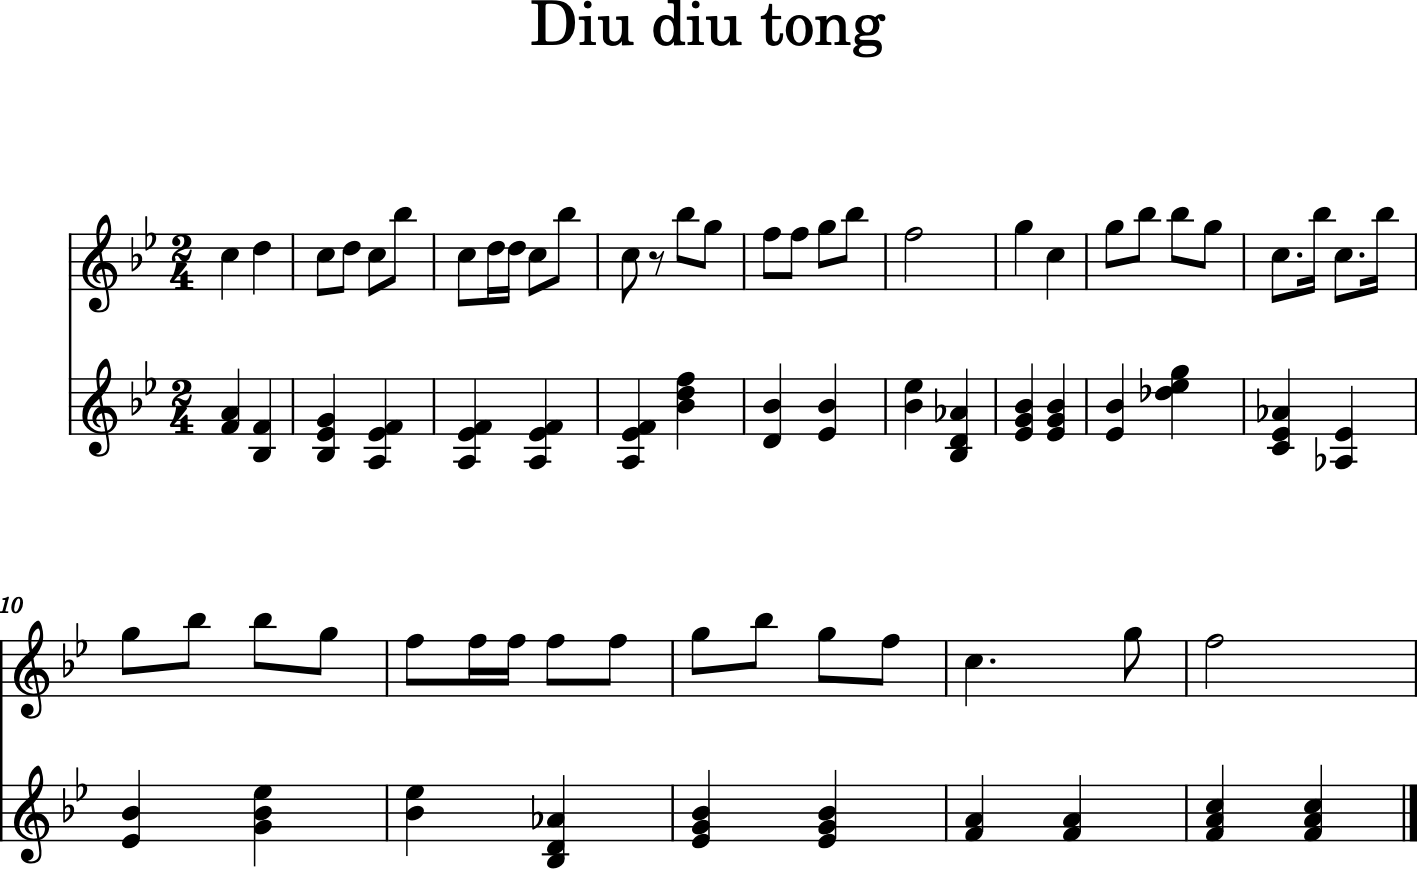

input song id (0-1234) (input -1 to exit):225


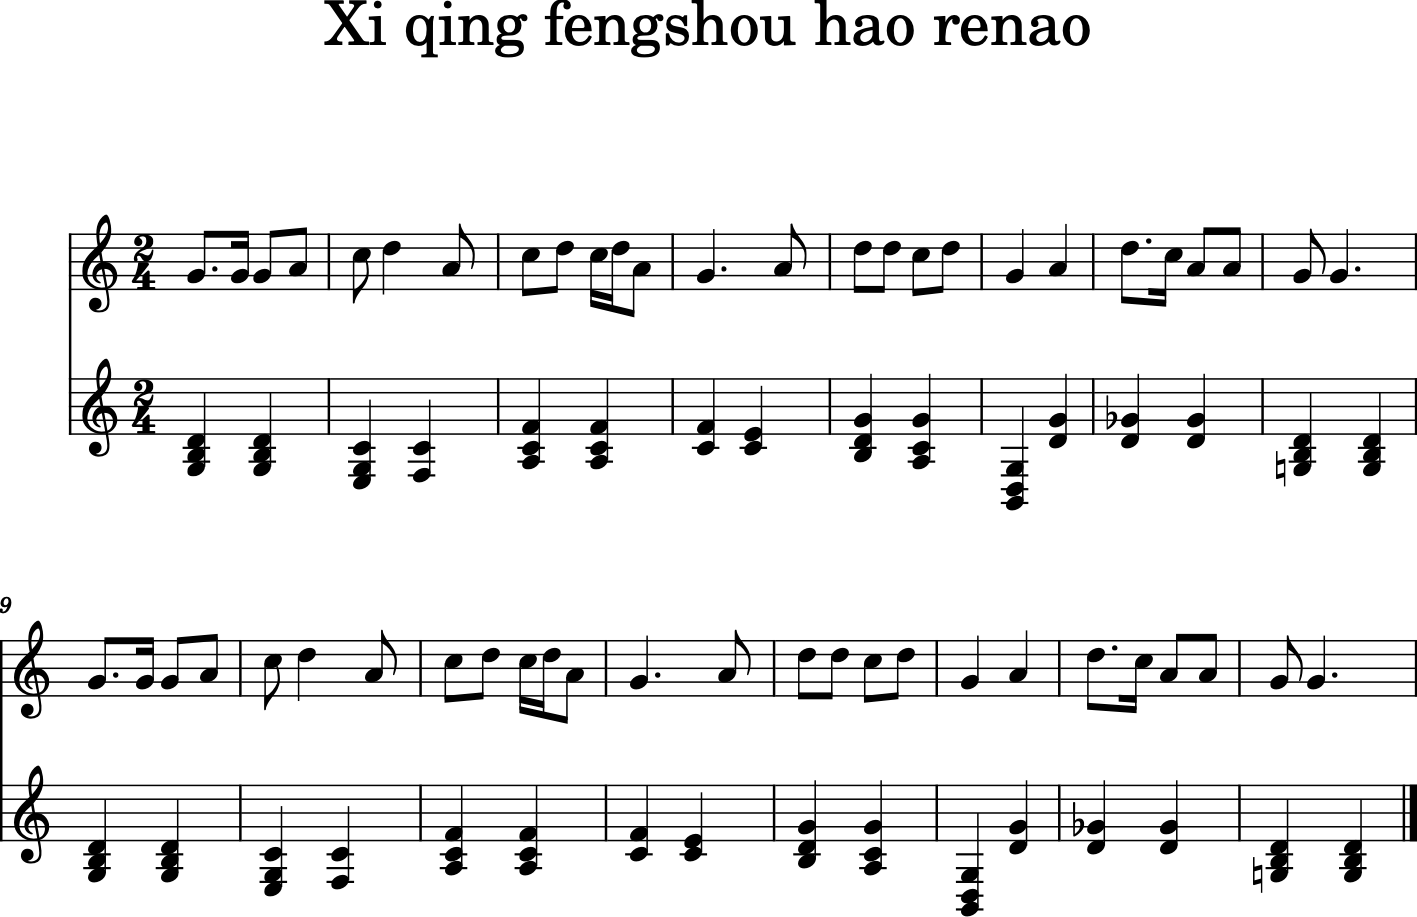

input song id (0-1234) (input -1 to exit):304


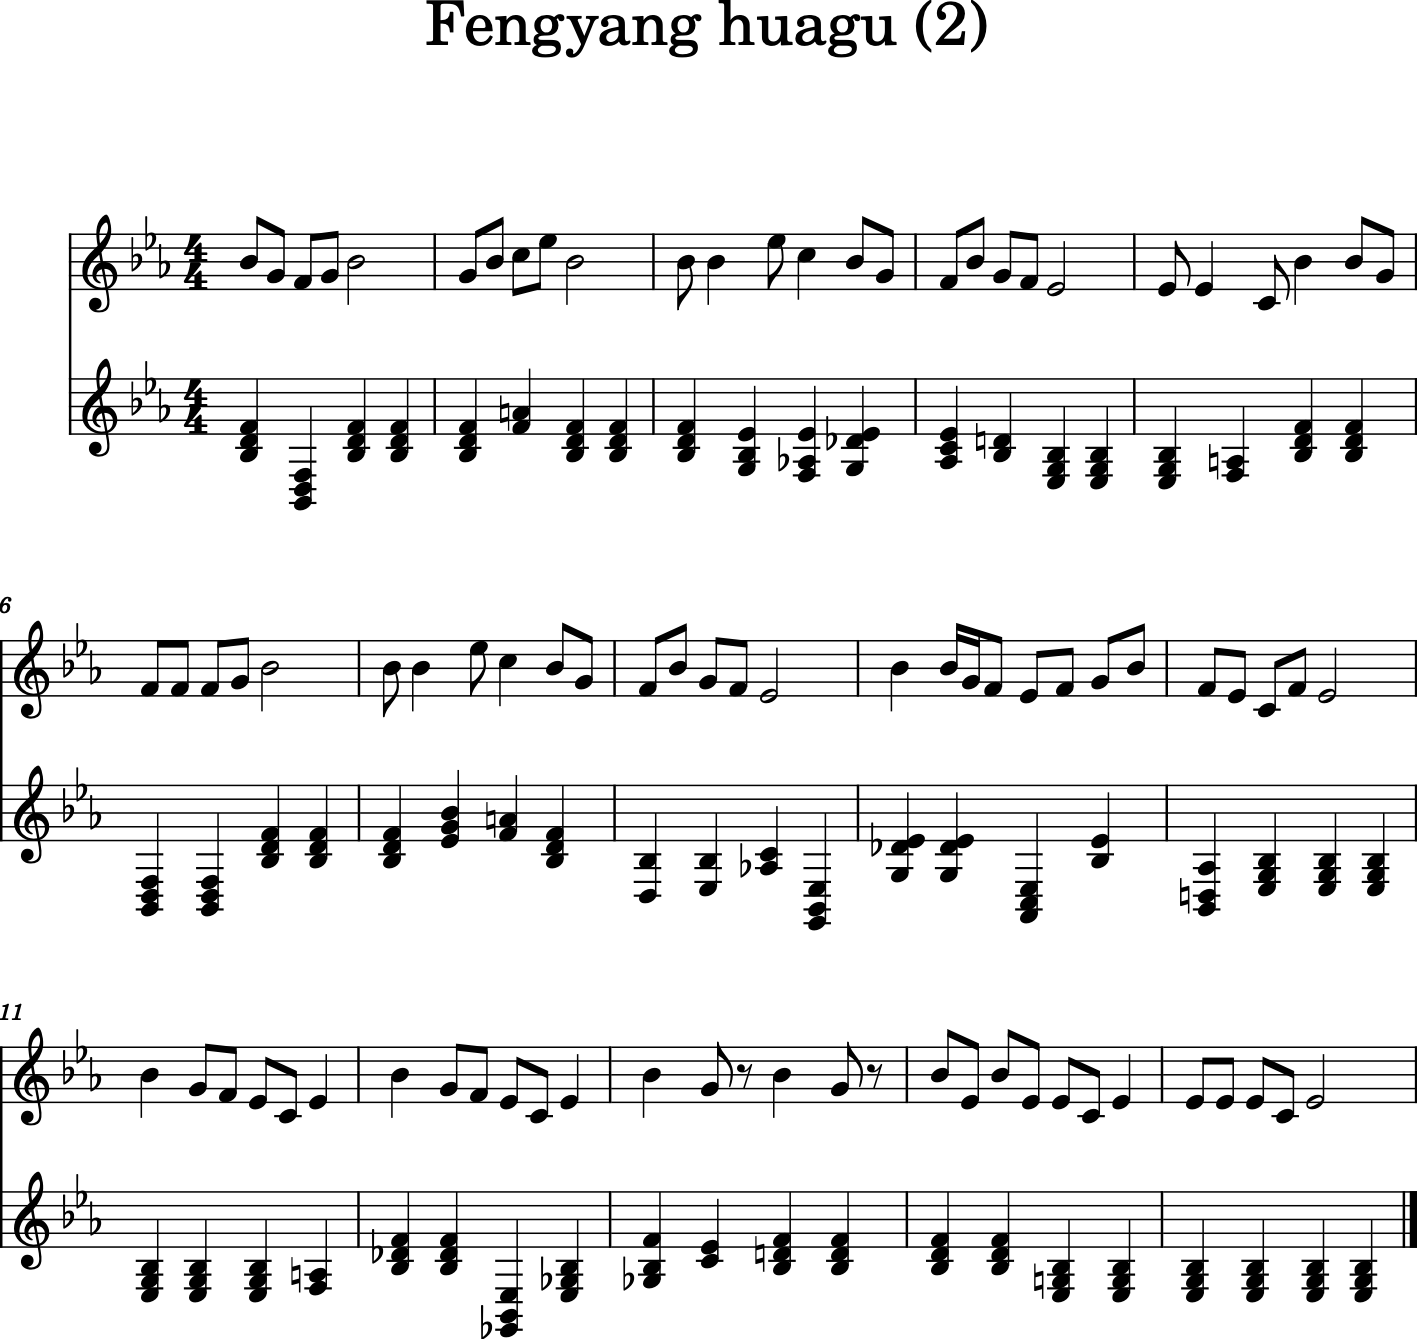

input song id (0-1234) (input -1 to exit):396


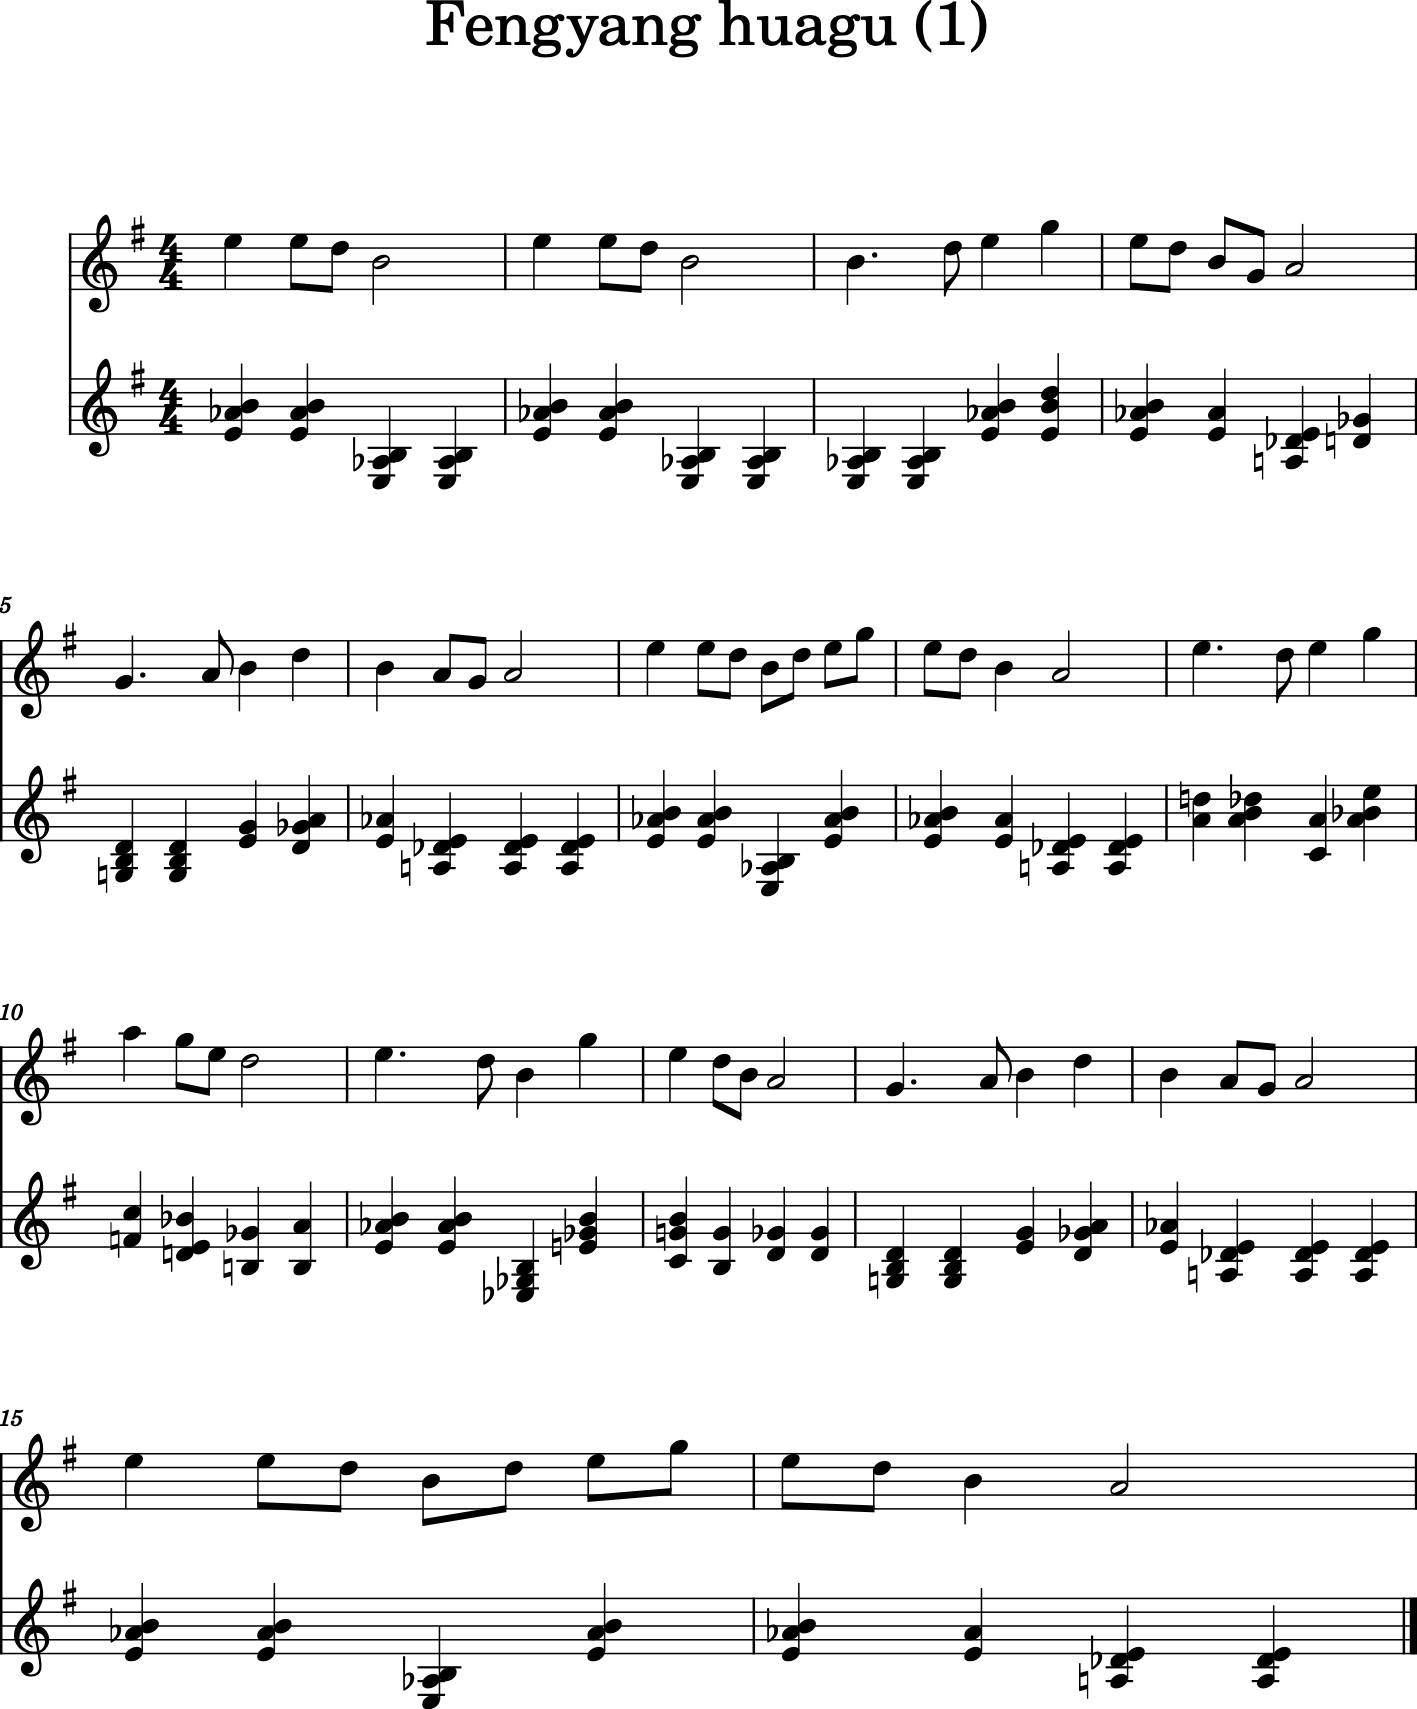

input song id (0-1234) (input -1 to exit):596


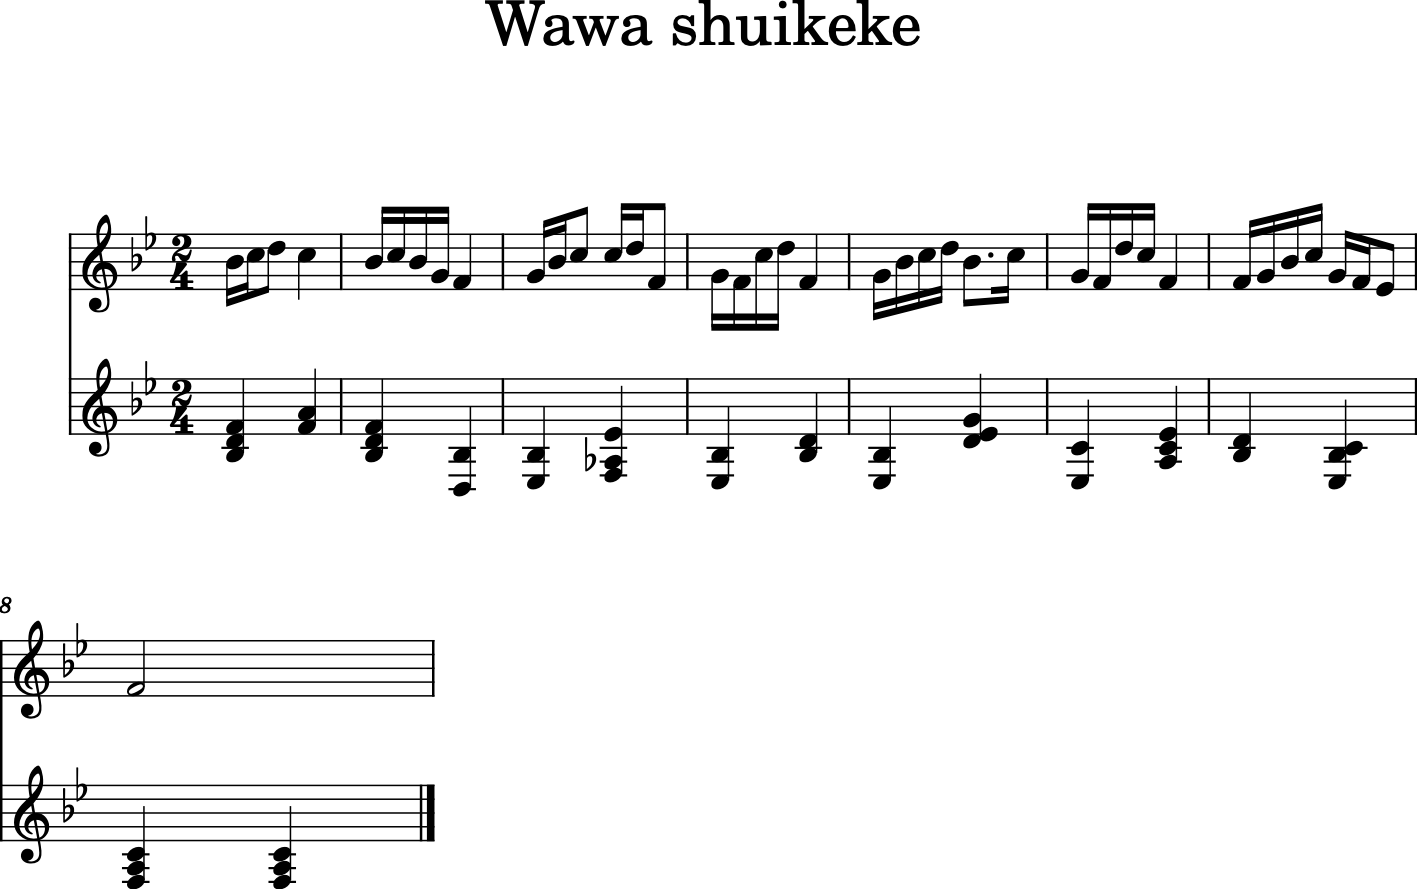

input song id (0-1234) (input -1 to exit):987


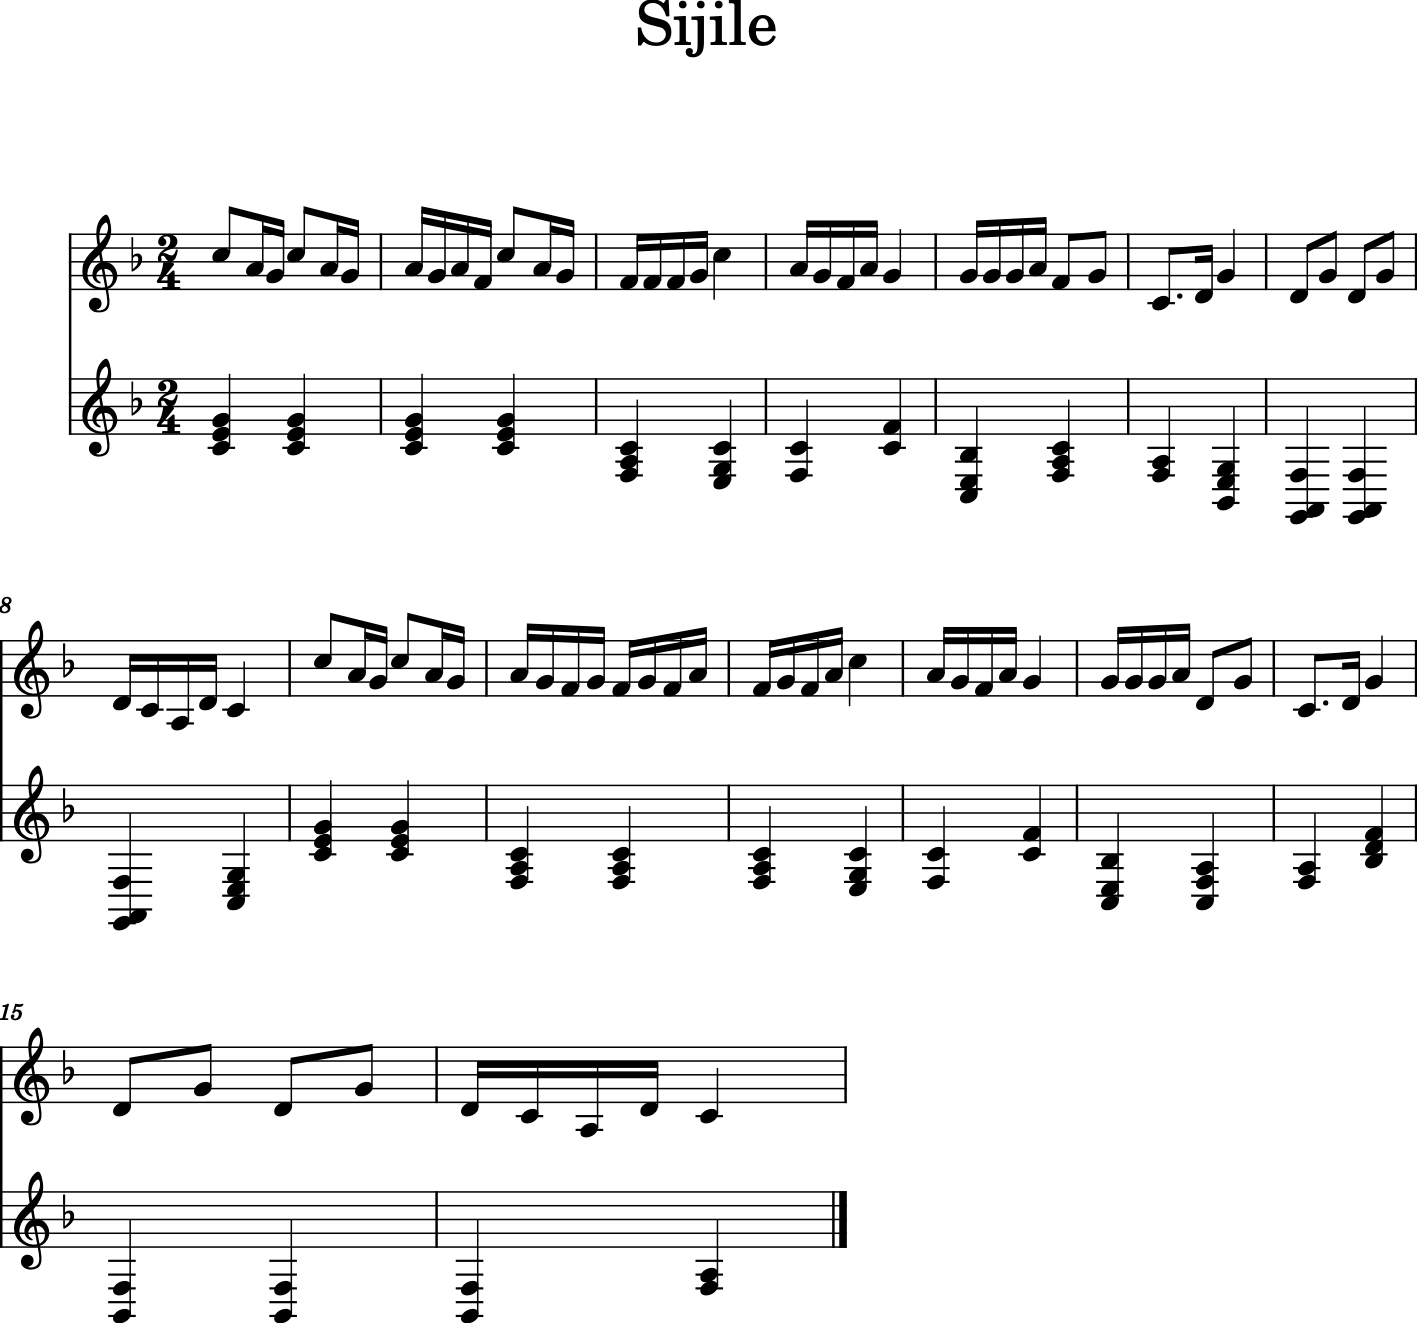

input song id (0-1234) (input -1 to exit):-1


<music21.metadata.bundles.MetadataBundle {1235 entries}>

In [3]:
#training with Bach's chorales to harmonize Chinese folks
def demo_train():
    bachBundle = corpus.search('bach', 'composer')
    bach_4parts=[e.parse() for e in bachBundle if e.metadata.numberOfParts==4]
    h=Harmonizer()
    h.train(bach_4parts)
    return h

def demo_harmonize(h,songs=None):
    if songs is None:
        songs=corpus.search('china','locale')
    while True:
        str_id=input("input song id (0-%d) (input -1 to exit):" %(len(songs)-1))
        song_id=int(str_id)
        if song_id==-1:
            return songs
       
        s=songs[song_id].parse()
        try:
            ns=h.harmonize(s)
            if ns is None:
                print("can't harmonize this song. please select other songs.")
                continue
            #s.show()
            ns.show()
            s.show('midi')
            ns.show('midi')
        except:
            raise
            print("something wrong with harmonizing this song. please select other songs.")
h=demo_train()
demo_harmonize(h)